In [1]:
from utils import get_path, load_data

TRAIN, TEST = load_data(
    'mimic3-mimic3', 'mimic3-mimic3_reference.csv',
    {
        'train': {'mimic3_A': 'mimic3_train_A', 'mimic3_B': 'mimic3_train_B'},
        'test': {'mimic3_A': 'mimic3_test_A', 'mimic3_B': 'mimic3_test_B'},
    }
)

In [7]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline

from dmatch.utils import NamedFeatureSelector

from utils import Model

input_features = TRAIN.drop('Y', axis=1).columns.to_list()

features = [
    'mean',
    'std',
    'var',
    #'frequency',
    'hellinger_distance',
    'ks_test',
    'scaled_hellinger_distance',
    'scaled_ks_test',
]

models = {
    'tree':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('tree', DecisionTreeClassifier())
            ]),
            {
                'tree__max_depth': [2], #range(2, 5),
                'tree__criterion': ['gini'], #['gini', 'entropy'],
                'tree__class_weight': [None], #['balanced',  None],
                'tree__min_samples_leaf': [30]
            }
        ),
    'forest':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('forest', RandomForestClassifier())
            ]),
            {
                'forest__n_estimators': [250], #range(100, 401, 50),
                'forest__criterion': ['entropy'], #['gini', 'entropy'],
                'forest__class_weight': ['balanced'], #['balanced', None],
                'forest__max_depth': [None],
                'forest__min_samples_leaf': [1]
            }
        ),
    'logistic':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced', None],
                'logit__C': np.logspace(2, 6, 10),
                'logit__tol': [1e-5],
                'logit__max_iter': np.linspace(10000, 20000, 5)
            }
        ),
    'kolmogorov-smirnov':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['ks_test'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced', None],
                'logit__C': np.logspace(2, 6, 10),
                'logit__tol': [1e-5],
            }
        ),
    'hellinger':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['hellinger_distance'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced', None],
                'logit__C': np.logspace(2, 6, 10),
                'logit__tol': [1e-5],
            }
        ),
    'mean':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['mean'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced', None],
                'logit__C': np.logspace(2, 6, 10),
                'logit__tol': [1e-5],
            }
        ),
    'std':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['std'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced', None],
                'logit__C': np.logspace(2, 6, 10),
                'logit__tol': [1e-5],
            }
        ),
}

for key, model in models.items():
    continue

model = models['logistic']
key = 'logistic'
print(f"{'='*5} {key} {'='*5}")
model.train(TRAIN)
print(model.best_params)
model.test(TEST, rep=10)
model.print_scores()
print()

===== logistic =====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
/home/mcourtois/.virtualenvs/dmatch/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcourtois/.virtualenvs/dmatch/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Figure(1800x1200)


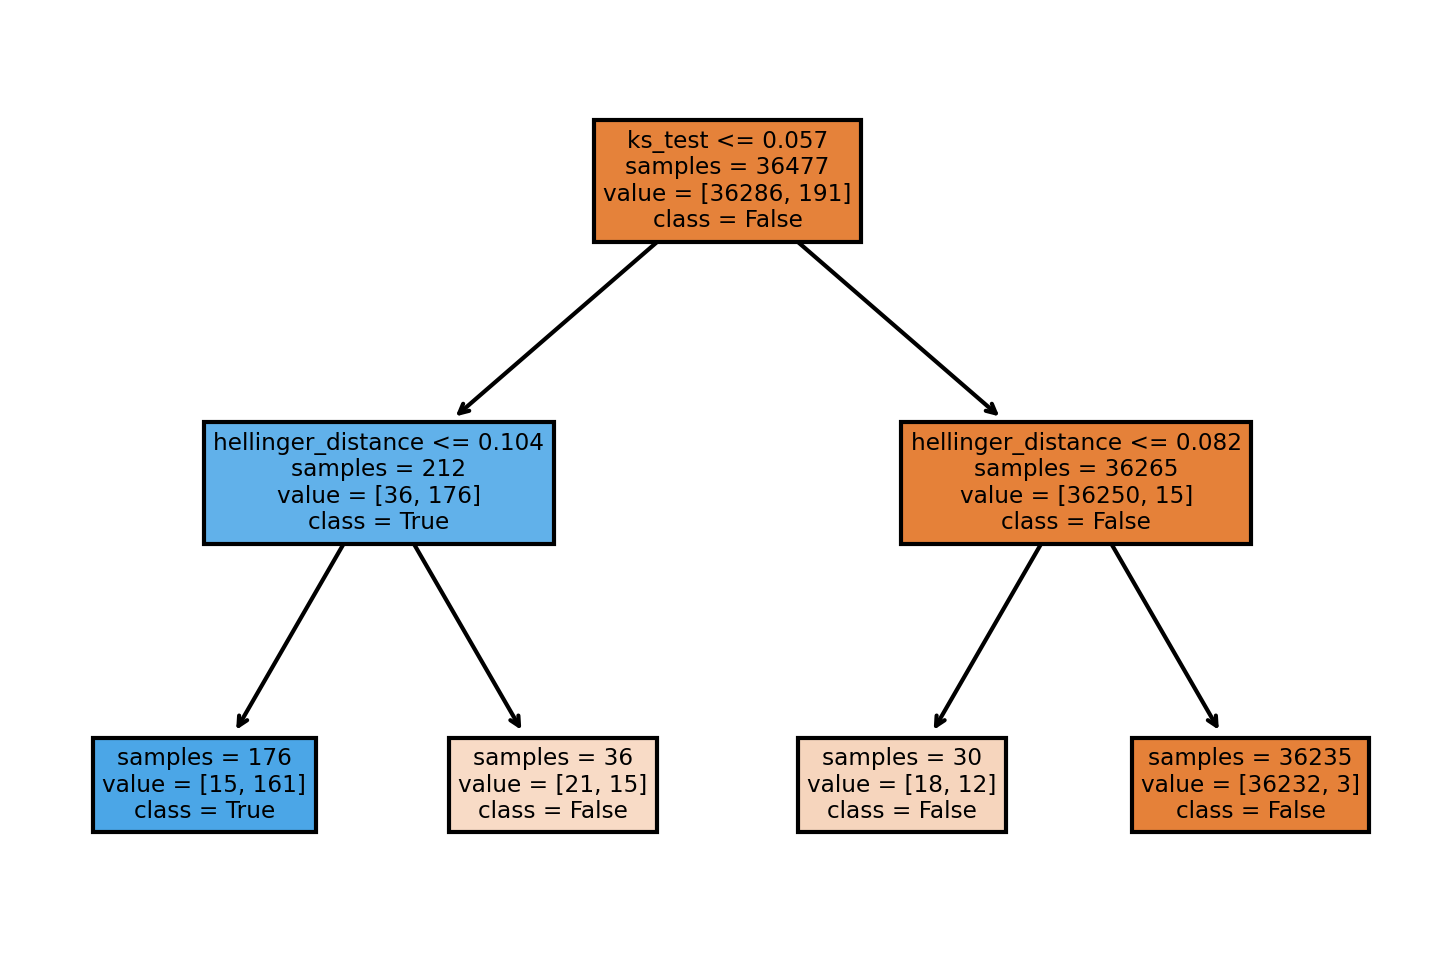

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def tree_fig(tree):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot()
    fig.patch.set_facecolor('#FFFFFF')
    plot_tree(
        tree,
        feature_names=features,
        class_names=["False", 'True'],
        filled=True,
        proportion=False,
        impurity=False,
        ax=ax
    )
    return fig

fig = tree_fig(model.best_model.named_steps['tree'])
print(fig)